<a href="https://colab.research.google.com/github/Andyqballer/Automatic-Detection-of-COVID-19-from-Chest-X-rays-CT-Scans-Using-Deep-Learning/blob/main/COVIDDetectionMultiplModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1124 images belonging to 3 classes.
Found 281 images belonging to 3 classes.
Found 1575 images belonging to 3 classes.

Training CNN Model:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - Precision: 1.0000 - Recall: 0.9563 - accuracy: 0.4916 - loss: -146.8793 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 0.5018 - val_loss: -4265.8159 - learning_rate: 0.0010
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 0.5074 - loss: -16511.5508 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 0.5018 - val_loss: -116589.7344 - learning_rate: 0.0010
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 0.4789 - loss: -227807.0312 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 0.5018 - val_loss: -802532.8125 - learning_rate: 0.0010
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 0.4957 - loss: -1182707.8750 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 0.5018 - val_loss: -3049352.0000 - learning_rate: 0.0010
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]


Training SVM Model:
 3/99 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


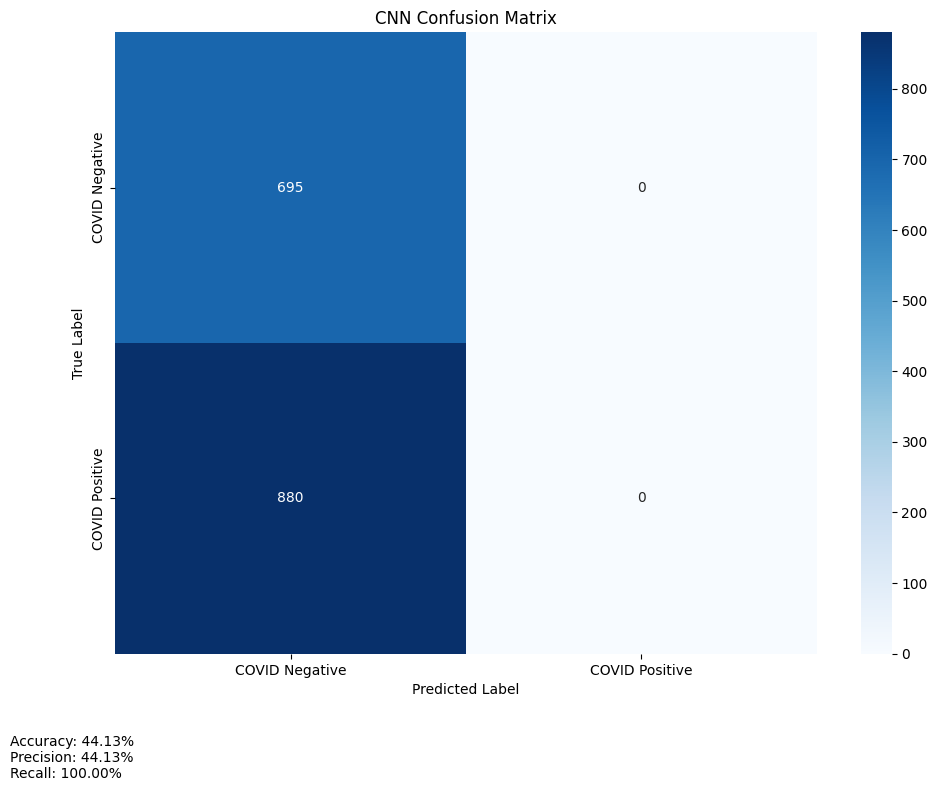

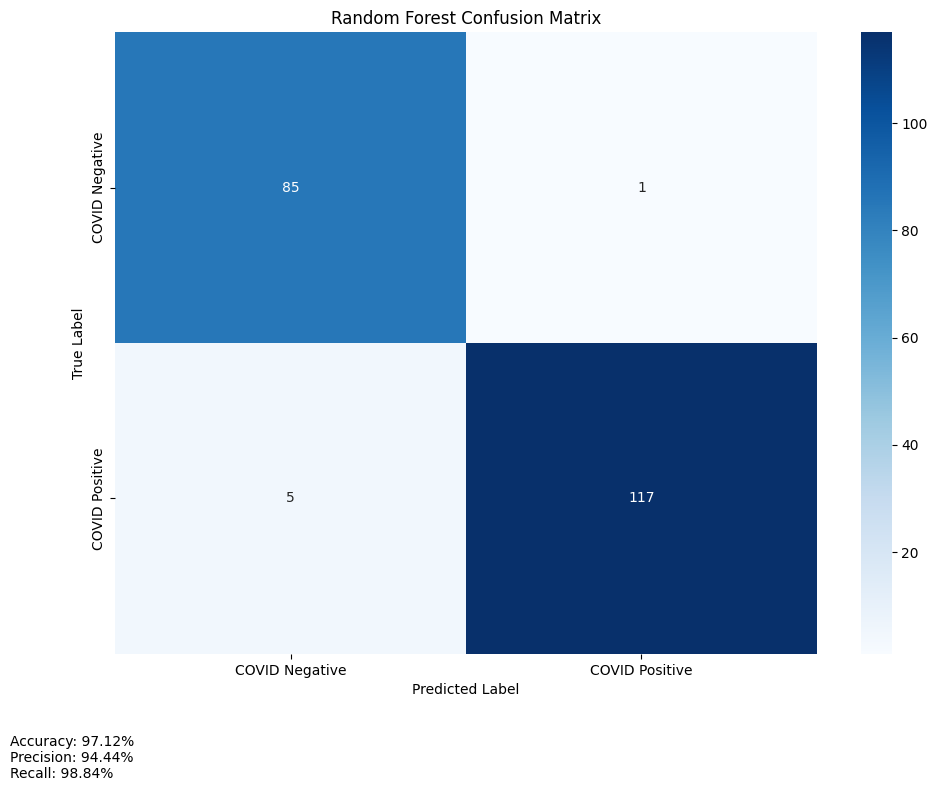

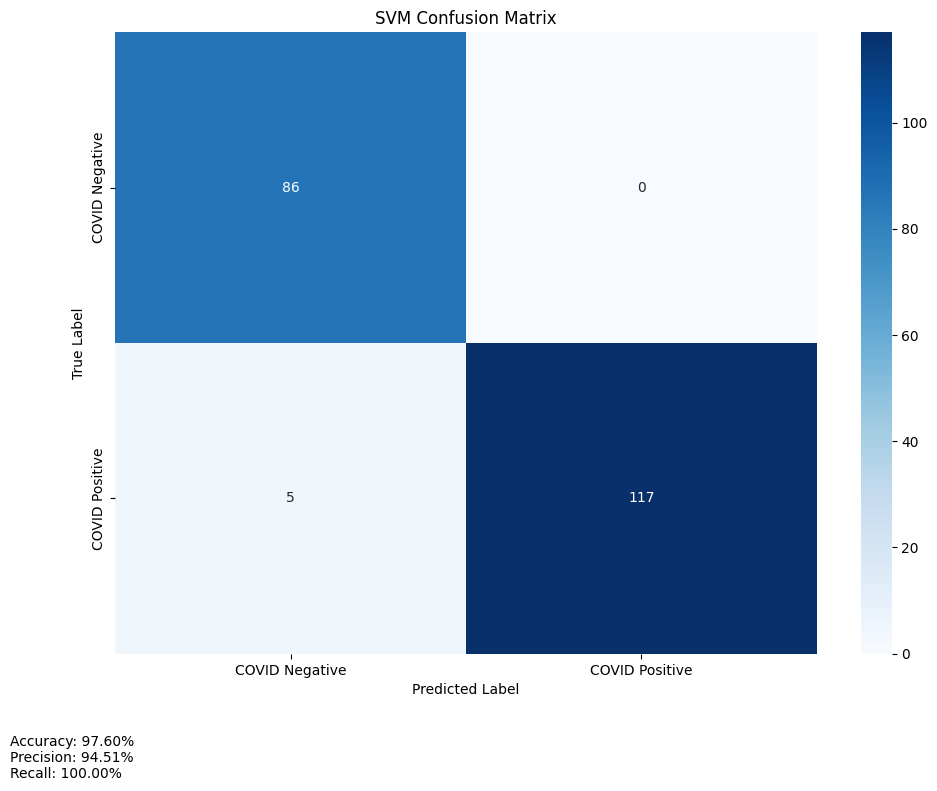

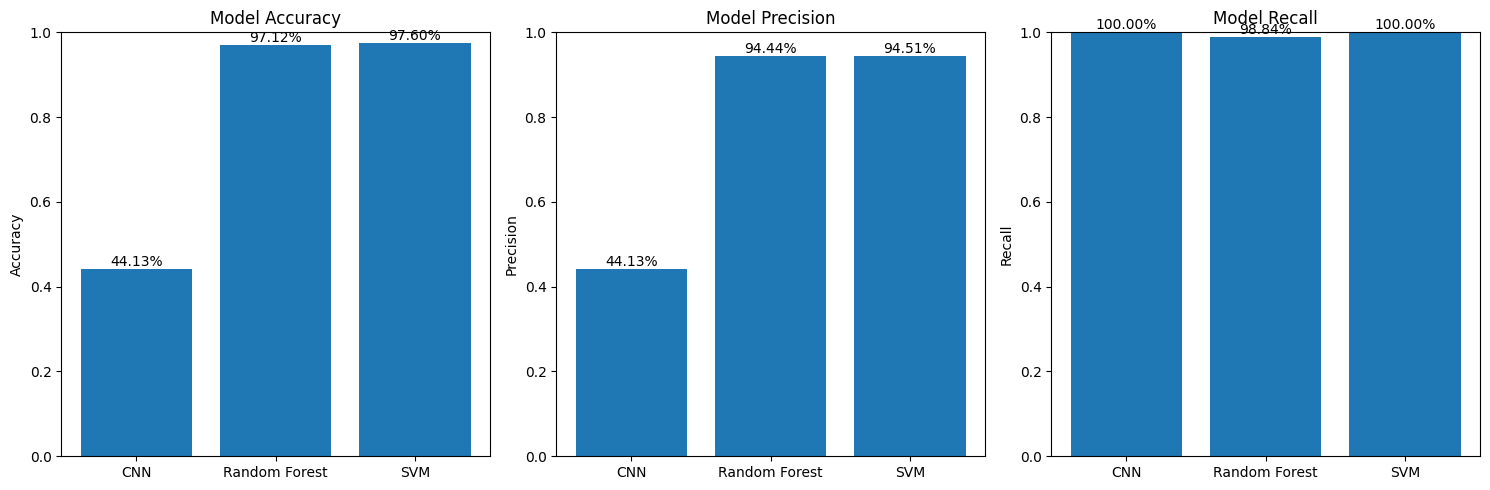

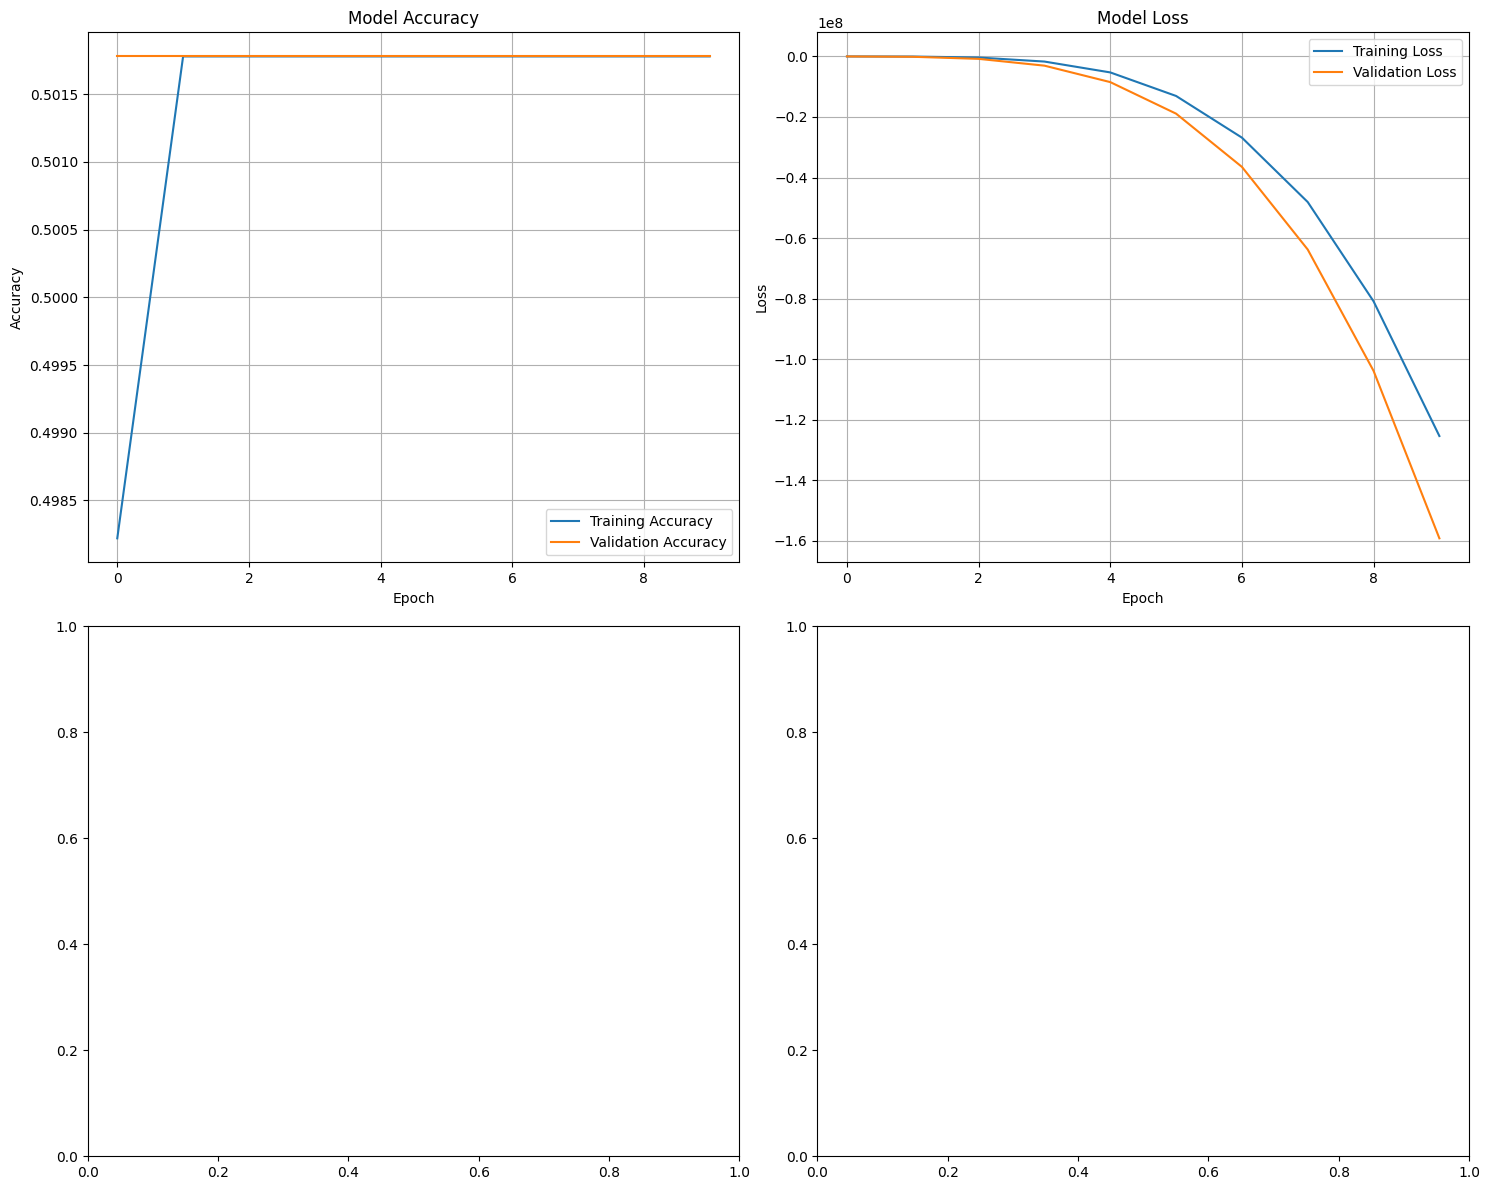

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from tqdm.notebook import tqdm

class EnhancedCOVIDDetectionAnalysis:
    def __init__(self, base_dir, target_size=(32, 32), batch_size=16):
        self.base_dir = base_dir
        self.target_size = target_size
        self.batch_size = batch_size
        self.model_results = {}
        self.histories = {}
        self.models = {}
        self.scalers = {}

    def prepare_data(self):
        # Data generators with minimal augmentation to save memory
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
        )

        test_datagen = ImageDataGenerator(rescale=1./255)

        # Using smaller batch size and target size for memory efficiency
        self.train_generator = train_datagen.flow_from_directory(
            os.path.join(self.base_dir, 'train'),
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='binary',
            subset='training'
        )

        self.val_generator = train_datagen.flow_from_directory(
            os.path.join(self.base_dir, 'train'),
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='binary',
            subset='validation'
        )

        self.test_generator = test_datagen.flow_from_directory(
            os.path.join(self.base_dir, 'test'),
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )

    def create_cnn_model(self):
        model = Sequential([
            Conv2D(16, (3, 3), activation='relu', input_shape=(*self.target_size, 3)),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'Precision', 'Recall']
        )

        return model

    def train_models(self, epochs=160):
        self.prepare_data()

        # 1. CNN Training
        print("\nTraining CNN Model:")
        cnn_model = self.create_cnn_model()

        # Add callbacks for better training
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ]

        history = cnn_model.fit(
            self.train_generator,
            validation_data=self.val_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

        self.histories['CNN'] = history
        self.models['CNN'] = cnn_model

        # 2. Optimized Random Forest Training
        print("\nTraining Random Forest Model:")

        # Process data in batches to save memory
        X_train, y_train = self._batch_process_data(self.train_generator, max_samples=1000)
        X_test, y_test = self._batch_process_data(self.test_generator, max_samples=200)

        # Scale features
        scaler_rf = StandardScaler()
        X_train_scaled = scaler_rf.fit_transform(X_train)
        X_test_scaled = scaler_rf.transform(X_test)
        self.scalers['Random Forest'] = scaler_rf

        # Train Random Forest with reduced number of trees
        rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
        rf_model.fit(X_train_scaled, y_train)
        self.models['Random Forest'] = rf_model

        # 3. SVM Training
        print("\nTraining SVM Model:")
        svm_model = SVC(kernel='rbf', probability=True, random_state=42)
        svm_model.fit(X_train_scaled, y_train)
        self.models['SVM'] = svm_model

        # Evaluate all models
        self._evaluate_models(X_test_scaled, y_test)

    def _batch_process_data(self, generator, max_samples):
        features = []
        labels = []
        samples_processed = 0

        for batch_x, batch_y in tqdm(generator):
            batch_features = batch_x.reshape(batch_x.shape[0], -1)
            features.append(batch_features)
            labels.append(batch_y)

            samples_processed += len(batch_y)
            if samples_processed >= max_samples:
                break

        return np.concatenate(features), np.concatenate(labels)

    def _evaluate_models(self, X_test_scaled, y_test):
        for model_name, model in self.models.items():
            if model_name == 'CNN':
                predictions = (model.predict(self.test_generator) > 0.5).astype(int)
                true_labels = self.test_generator.classes
            else:
                predictions = model.predict(X_test_scaled)
                true_labels = y_test

            self.model_results[model_name] = {
                'accuracy': accuracy_score(true_labels, predictions),
                'precision': precision_score(true_labels, predictions),
                'recall': recall_score(true_labels, predictions),
                'predictions': predictions,
                'true_labels': true_labels
            }

            # Plot confusion matrix
            self._plot_enhanced_confusion_matrix(
                true_labels,
                predictions,
                title=f'{model_name} Confusion Matrix'
            )

        # Plot model comparison
        self._plot_model_comparison()

        if 'CNN' in self.histories:
            self._plot_enhanced_training_history(self.histories['CNN'])

    def _plot_enhanced_confusion_matrix(self, y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['COVID Negative', 'COVID Positive'],
                    yticklabels=['COVID Negative', 'COVID Positive'])
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

        # Add metrics
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)

        plt.text(-0.15, -0.2, f'Accuracy: {acc:.2%}\nPrecision: {prec:.2%}\nRecall: {rec:.2%}',
                transform=plt.gca().transAxes)
        plt.tight_layout()
        plt.show()

    def _plot_enhanced_training_history(self, history):
        metrics = ['accuracy', 'loss', 'precision', 'recall']
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()

        for idx, metric in enumerate(metrics):
            if metric in history.history:
                axes[idx].plot(history.history[metric], label=f'Training {metric.capitalize()}')
                axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
                axes[idx].set_title(f'Model {metric.capitalize()}')
                axes[idx].set_xlabel('Epoch')
                axes[idx].set_ylabel(metric.capitalize())
                axes[idx].legend()
                axes[idx].grid(True)

        plt.tight_layout()
        plt.show()

    def _plot_model_comparison(self):
        metrics = ['accuracy', 'precision', 'recall']
        fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

        for idx, metric in enumerate(metrics):
            values = [self.model_results[model][metric] for model in self.model_results]
            bars = axes[idx].bar(self.model_results.keys(), values)
            axes[idx].set_title(f'Model {metric.capitalize()}')
            axes[idx].set_ylabel(metric.capitalize())
            axes[idx].set_ylim(0, 1)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2%}',
                        ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def detect_covid(self, image_path):
        """Detect COVID-19 using all trained models"""
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at {image_path}")

        # Preprocess image
        img = load_img(image_path, target_size=self.target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        results = {}

        # Get predictions from all models
        for model_name, model in self.models.items():
            if model_name == 'CNN':
                pred = model.predict(img_array)[0][0]
                result = 'COVID Positive' if pred > 0.5 else 'COVID Negative'
                confidence = pred if pred > 0.5 else 1 - pred
            else:
                # Flatten and scale image for traditional ML models
                img_flat = img_array.reshape(1, -1)
                img_scaled = self.scalers[model_name].transform(img_flat)

                if model_name == 'Random Forest':
                    pred_proba = model.predict_proba(img_scaled)[0]
                    result = 'COVID Positive' if pred_proba[1] > 0.5 else 'COVID Negative'
                    confidence = max(pred_proba)
                else:  # SVM
                    pred = model.predict(img_scaled)[0]
                    result = 'COVID Positive' if pred == 1 else 'COVID Negative'
                    confidence = abs(model.decision_function(img_scaled)[0])

            results[model_name] = {'result': result, 'confidence': confidence}

            print(f"\n{model_name} Detection Result:")
            print(f"Prediction: {result}")
            print(f"Confidence: {confidence:.2%}")

        return results

def main():
    try:
        base_dir = '/content/dataset'
        analyzer = EnhancedCOVIDDetectionAnalysis(base_dir)
        analyzer.train_models(epochs=10)

        # Example of COVID detection
        test_image_path = '/content/dataset/test/covid/example.jpg'  # Update path
        if os.path.exists(test_image_path):
            results = analyzer.detect_covid(test_image_path)

    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()